In [1]:
import os

os.environ[
    "OMP_NUM_THREADS"
] = "64"  # for jupyter.nersc.gov otherwise the notebook only uses 2 cores

In [2]:
from pathlib import Path
import healpy as hp
import matplotlib.pyplot as plt
import numpy as np
import pymaster as nmt
from astropy.io import fits

%matplotlib inline

In [3]:
plt.style.use("seaborn-talk")

In [4]:
import pysm3 as pysm
import pysm3.units as u

In [5]:
nside = 2048
lmax = 2048

In [6]:
comp = "IQU"

In [7]:
components = list(enumerate(comp))
components

[(0, 'I'), (1, 'Q'), (2, 'U')]

In [8]:
spectra_components = ["TT", "EE", "BB"]

change this to True   if you want to  run namaster on notebook 


In [9]:
namaster_on_nb = True

In [10]:
datadir = Path("data/")

In [11]:
proddatadir = Path("production-data") / "dust_gnilc" / "raw"

# Setting the inputs 
## Dust maps 
- We use the  2015 GNILC intensity map from the 2nd planck release, as it encodes less contamination from CIB with 21.8' resolution https://www.dropbox.com/s/hicocet83z31ob3/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits?dl=0

- for Q and U we adopt maps from the 3rd Planck release as they were optimized for polarization studies with 80' reso.  



In [12]:
dust_varresI = datadir / "COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits"

In [13]:
if not dust_varresI.exists():
    !wget -O $dust_varresI https://portal.nersc.gov/project/cmb/pysm-data/gnilc/inputs/COM_CompMap_Dust-GNILC-F353_2048_21p8acm.fits

Transform maps to double precision for computations

In [14]:
I_planck_varres, h = hp.read_map(dust_varresI, dtype=np.float64, h=True)

Maps from the two releases are in different units `MJy/sr` the former, and `K_CMB` the latter, we therefore need to perform some conversion to `uK_RJ`. 

In [15]:
I_planck_varres <<= u.MJy / u.sr
I_planck_varres = I_planck_varres.to(
    "uK_RJ", equivalencies=u.cmb_equivalencies(353 * u.GHz)
)

In [16]:
output_nside = 8192
output_lmax = 2 * output_nside

## Amplitude modulation

In [17]:
modulate_amp = hp.alm2map(
    hp.read_alm(
        proddatadir / "gnilc_dust_temperature_modulation_alms_lmax768.fits.gz",
    ).astype(np.complex128),
    nside=output_nside,
)

## Injecting small scales to Spectral parameters 

In [18]:
tdfile = datadir / "COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits"
if not tdfile.exists():
    !wget -O $tdfile  http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Model-Temperature_2048_R2.00.fits
bdfile = datadir / "COM_CompMap_Dust-GNILC-Model-Spectral-Index_2048_R2.00.fits"

if not bdfile.exists():
    !wget -O $bdfile http://pla.esac.esa.int/pla/aio/product-action?MAP.MAP_ID=COM_CompMap_Dust-GNILC-Model-Spectral-Index_2048_R2.00.fits

In [19]:
td = hp.read_map(tdfile, dtype=np.float64)
bd = hp.read_map(bdfile, dtype=np.float64)

In [20]:
cltd = hp.anafast(td, use_pixel_weights=True, lmax=lmax)
clbd = hp.anafast(bd, use_pixel_weights=True, lmax=lmax)

cl = {"bd": clbd, "td": cltd}
dust_params = list(cl.keys())
ell = np.arange(lmax + 1)

In [21]:
from scipy.optimize import curve_fit

In [22]:
def model(ell, A, gamma):
    out = A * ell ** gamma
    out[:2] = 0
    return out

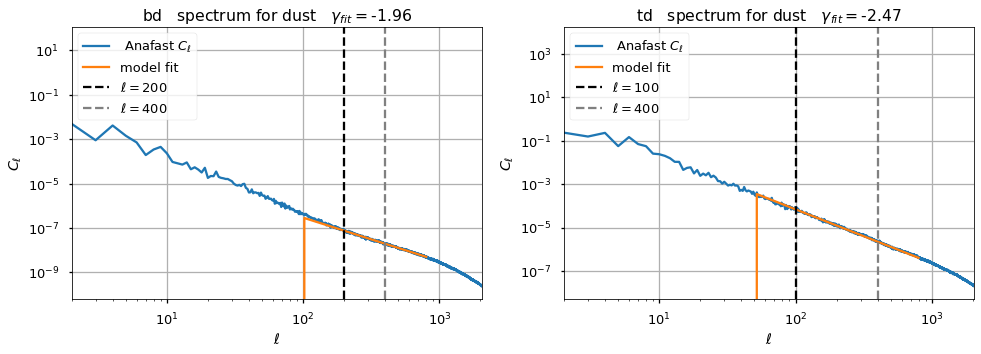

In [23]:
ell_fit_low = {"bd": 200, "td": 100}
ell_fit_high = {"bd": 400, "td": 400}

A_fit, gamma_fit, A_fit_std, gamma_fit_std = {}, {}, {}, {}
plt.figure(figsize=(25, 5))

for ii, pol in enumerate(dust_params):
    plt.subplot(131 + ii)
    xdata = np.arange(ell_fit_low[pol], ell_fit_high[pol])
    ydata = cl[pol][xdata]
    (A_fit[pol], gamma_fit[pol]), cov = curve_fit(model, xdata, ydata)

    A_fit_std[pol], gamma_fit_std[pol] = np.sqrt(np.diag(cov))
    plt.loglog(ell, cl[pol], label=" Anafast $C_\ell$")

    plt.plot(
        ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 2],
        model(
            ell[ell_fit_low[pol] // 2 : ell_fit_high[pol] * 2],
            A_fit[pol],
            gamma_fit[pol],
        ),
        label="model fit",
    )

    plt.axvline(
        ell_fit_low[pol],
        linestyle="--",
        color="black",
        label="$ \ell={} $".format(ell_fit_low[pol]),
    )
    plt.axvline(
        ell_fit_high[pol],
        linestyle="--",
        color="gray",
        label="$ \ell={} $".format(ell_fit_high[pol]),
    )
    plt.legend()
    plt.grid()
    plt.title(
        f"{pol}   spectrum for dust   " + r"$\gamma_{fit}=$" + f"{gamma_fit[pol]:.2f}"
    )

    plt.ylabel("$ C_\ell $")
    plt.xlabel(("$\ell$"))
    plt.xlim(2, lmax)

- We inject smaller angular scales to the maps  by extrapolating the power law fitted from the GNILC spectral parameter maps 

- Smaller angular scales are modulated similarly as the intensity map in pol tens formalism. 

- the multipoles where the fit is performed are different given the observed spectra . In any case we don't fit beyond $\ell=400$, which is consistent with the TT analysis above 
- given the fact that we inject smaller angular scales with a steeper spectral index  than TT
$$\gamma_{\beta} = -1.96, \gamma_{Td} = -2.47, \gamma_{TT}= -1.29$$

we don't expect to injecti _small scale noise_ when rescaling at frequencies orders of magnitude lower or larger than  the reference one ( 353 GHz). 


In [24]:
def sigmoid(x, x0, width, power=4):
    """Sigmoid function given start point and width
    Parameters
    ----------
    x : array
        input x axis
    x0 : float
        value of x where the sigmoid starts (not the center)
    width : float
        width of the transition region in unit of x
    power : float
        tweak the steepness of the curve
    Returns
    -------
    sigmoid : array
        sigmoid, same length of x"""
    return 1.0 / (1 + np.exp(-power * (x - x0 - width / 2) / width))

### Small scales

In [25]:
# filter small scales
small_scales_input_cl = [
    1
    * model(ell, A_fit[pol], gamma_fit[pol])
    * (sigmoid(ell, ell_fit_high[pol], ell_fit_high[pol] / 10))
    for pol in dust_params
]

names = ["beta", "Td"]

for name, each in zip(names, small_scales_input_cl):
    hp.write_cl(
        proddatadir / f"gnilc_dust_small_scales_{name}_cl_lmax{output_lmax}.fits",
        each,
        dtype=np.complex128,
        overwrite=True,
    )
    pysm.utils.add_metadata(
        [proddatadir / f"gnilc_dust_small_scales_{name}_cl_lmax{output_lmax}.fits"],
        unit="K**2" if name == "Td" else "",
    )


np.random.seed(777)
bd_ss_alm = hp.synalm(small_scales_input_cl[0], lmax=output_lmax)
np.random.seed(888)
td_ss_alm = hp.synalm(small_scales_input_cl[1], lmax=output_lmax)


bd_ss = hp.alm2map(bd_ss_alm, nside=output_nside)
td_ss = hp.alm2map(td_ss_alm, nside=output_nside)


bd_ss *= modulate_amp
td_ss *= modulate_amp

/tmp/ipykernel_265480/3589521984.py:2: RuntimeWarning: divide by zero encountered in power
  out = A * ell ** gamma


### Large scales

In [26]:
largescale_lmax = 1024

In [27]:
alm_bd = hp.map2alm(bd, lmax=largescale_lmax, use_pixel_weights=True)
alm_td = hp.map2alm(td, lmax=largescale_lmax, use_pixel_weights=True)

sig_func = sigmoid(ell, x0=ell_fit_high["bd"], width=ell_fit_high["bd"] / 10)
bd_LS_alm = hp.almxfl(alm_bd, np.sqrt(1.0 - sig_func))
td_LS_alm = hp.almxfl(alm_td, np.sqrt(1.0 - sig_func))

for name, alm in zip(names, [bd_ss_alm, td_ss_alm]):

    hp.write_alm(
        proddatadir
        / f"gnilc_dust_largescale_template_{name}_alm_nside{nside}_lmax{largescale_lmax:d}.fits",
        alm,
        lmax=largescale_lmax,
        out_dtype=np.complex64,
        overwrite=True,
    )

pysm.utils.add_metadata(
    [
        proddatadir
        / f"gnilc_dust_largescale_template_beta_alm_nside{nside}_lmax{largescale_lmax:d}.fits"
    ],
    coord="G",
    unit="",
)
pysm.utils.add_metadata(
    [
        proddatadir
        / f"gnilc_dust_largescale_template_Td_alm_nside{nside}_lmax{largescale_lmax:d}.fits"
    ],
    coord="G",
    unit="K",
)

bd_ls = hp.alm2map(bd_LS_alm, nside=output_nside)
td_ls = hp.alm2map(td_LS_alm, nside=output_nside)

### Final map

In [28]:
bd_out = bd_ss + bd_ls
td_out = td_ss + td_ls

In [29]:
# hp.write_map(
#     datadir / f"gnilc_dust_beta_map_nside{output_nside}.fits",
#     bd_out,
#     dtype=np.float32,
#     coord="G",
#     column_units="",
#     overwrite=True,
# )

In [30]:
# hp.write_map(
#     datadir / f"gnilc_dust_Td_map_nside{output_nside}.fits",
#     td_out,
#     dtype=np.float32,
#     coord="G",
#     column_units="K",
#     overwrite=True,
# )

In [31]:
cl_out = {
    "bd": hp.anafast(bd_out, use_pixel_weights=True, lmax=lmax),
    "td": hp.anafast(td_out, use_pixel_weights=True, lmax=lmax),
}

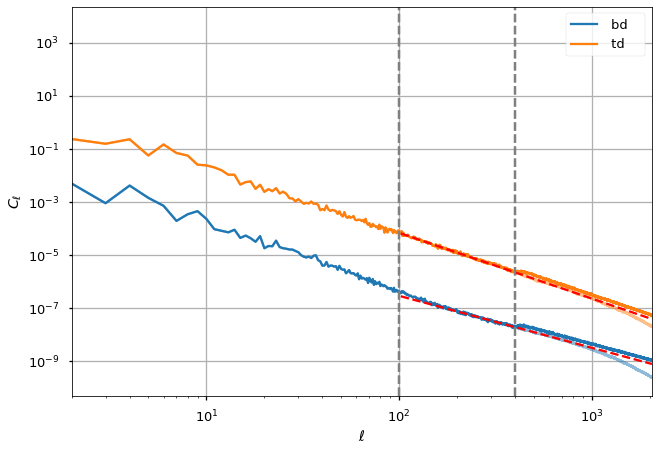

In [32]:
for ii, pol in enumerate(dust_params):
    plt.loglog(ell, cl[pol], alpha=0.5, color="C%d" % ii)
    plt.loglog(ell, cl_out[pol], label=f" {pol}   ", color="C%d" % ii)

    plt.legend()
    plt.grid(True)
    plt.plot(
        ell[100:][2:],
        model(ell[100:], A_fit[pol], gamma_fit[pol])[2:],
        "--",
        color="red",
    )
    plt.axvline(ell_fit_high[pol], linestyle="--", color="gray")
    plt.axvline(100, linestyle="--", color="gray")

    plt.ylabel("$ C_\ell $")
    plt.xlabel(("$\ell$"))
    # plt.xlim(350, 500 )
    plt.xlim(2, lmax)

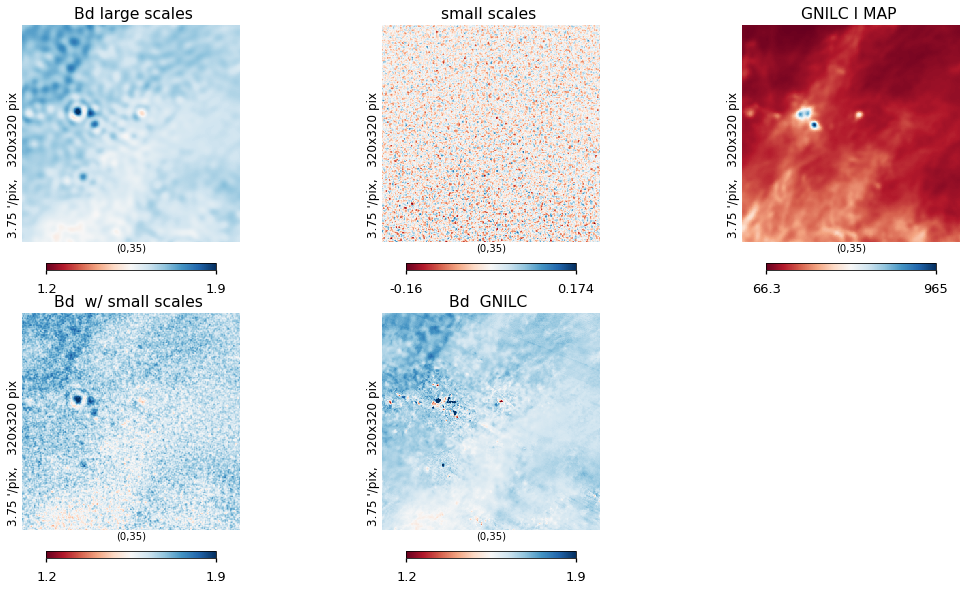

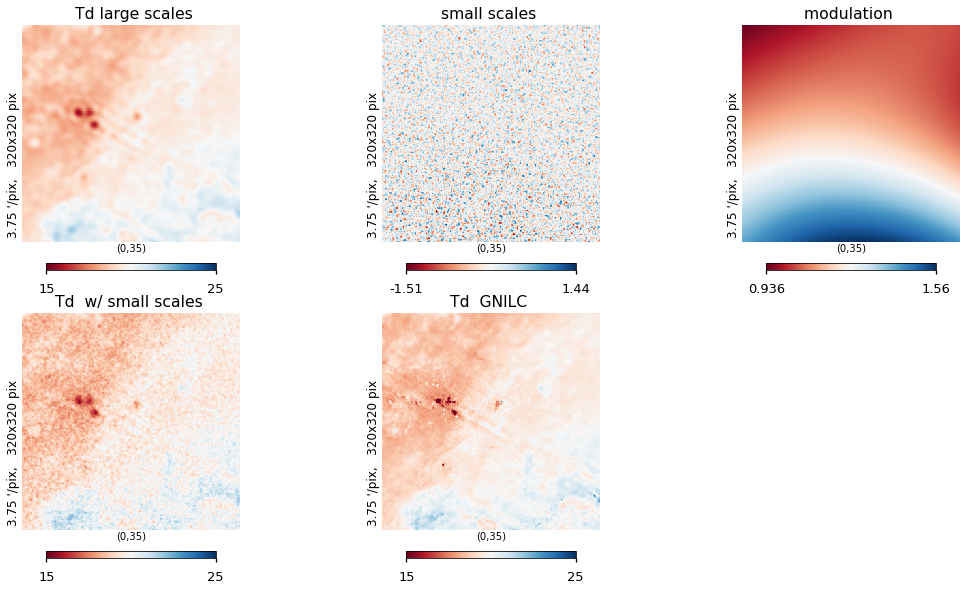

In [33]:
lat = 35
cm = plt.cm.RdBu
plt.figure(figsize=(15, 8))
hp.gnomview(
    bd_out,
    title="Bd  w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    cmap=cm,
    xsize=320,
    sub=234,
    min=1.2,
    max=1.9,
)
hp.gnomview(
    bd_ss, title="small scales ", rot=[0, lat], reso=3.75, xsize=320, cmap=cm, sub=232
)
hp.gnomview(
    I_planck_varres,
    title=" GNILC I MAP  ",
    rot=[0, lat],
    reso=3.75,
    cmap=cm,
    xsize=320,
    sub=233,
)

hp.gnomview(
    (bd),
    title=" Bd  GNILC  ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    cmap=cm,
    sub=235,
    min=1.2,
    max=1.9,
)
hp.gnomview(
    bd_ls,
    title="  Bd large scales ",
    rot=[0, lat],
    reso=3.75,
    cmap=cm,
    xsize=320,
    sub=231,
    min=1.2,
    max=1.9,
)

plt.figure(figsize=(15, 8))
hp.gnomview(
    td_out,
    title="Td  w/ small scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    cmap=cm,
    sub=234,
    min=15,
    max=25,
)
hp.gnomview(
    td_ss, title="small scales ", rot=[0, lat], reso=3.75, xsize=320, sub=232, cmap=cm
)
hp.gnomview(
    (modulate_amp),
    title=" modulation  ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    cmap=cm,
    sub=233,
)

hp.gnomview(
    (td),
    title=" Td  GNILC  ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    sub=235,
    cmap=cm,
    min=15,
    max=25,
)
hp.gnomview(
    td_ls,
    title="  Td large scales ",
    rot=[0, lat],
    reso=3.75,
    xsize=320,
    cmap=cm,
    sub=231,
    min=15,
    max=25,
)